In [1]:
import torch as torch
import os
import librosa
from matplotlib import pyplot as plt
import numpy as np
import csv
import python_speech_features as psf

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from collections import OrderedDict
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from models.vowel_recognition_nodel import *

## 1. Processing Data 

### Input block

In [3]:
disk_root_dir = "E:/"
dataset_path = "MASC/VocalSet/FULL"
output_path_train = "C:/Users/evansamaa/Desktop/Dataset/train"
output_path_test = "C:/Users/evansamaa/Desktop/Dataset/test"
segment_length = 1.5 # seconds
silence_threshold = 0.1
n_mfcc = 13
segment_length = int(segment_length * 100)

### Constant block

In [4]:
trainset_f = ["female1","female3","female4","female5","female6","female7","female9"]
trainset_m = ["male1", "male2", "male4","male6","male7","male8","male9","male11"]
train_set = trainset_f + trainset_m
test_set = ["female2", "female8", "male3", "male5", "male10"]
arpeggio_styles = ["belt", "breathy", "fast_forte", "fast_piano", "slow_forte", "slow_piano", "straight", "vibrato", "vocal_fry"]
tasks = ["arpeggios", "long_tones", "scales"]
long_tone_styles = ["forte", "inhaled", "messa", "pp", "straight", "trill", "trillo"]
task_styles = {0:arpeggio_styles, 1:long_tone_styles, 2:arpeggio_styles,
         "arpeggios":arpeggio_styles, "long_tones":long_tone_styles, "scales":arpeggio_styles}
vowels = ["a", "e", "i", "o", "u"]
vowels_dict = {"a":0, "e":1, "i":2, "o":3, "u":4}

# output_path_train = os.path.join(disk_root_dir, output_path_train)
# output_path_test = os.path.join(disk_root_dir, output_path_test)

### 1.1 walk the directory structure

In [4]:
# do a walk and keep all the good examples
training_data_folders = []
dataset_path = os.path.join(disk_root_dir, dataset_path)
# lets do a walk across all the folders for the training set
for singer in train_set:
    for task in tasks:
        styles = task_styles[task]
        for style in styles:
            path = os.path.join(dataset_path, singer, task, style)
            try:
                os.listdir(path)
                training_data_folders.append(path)
            except:
                print(path, "is missing frrom the dataset")
                
# do the same for testing set
testing_data_folders = []
for singer in test_set:
    for task in tasks:
        styles = task_styles[task]
        for style in styles:
            path = os.path.join(dataset_path, singer, task, style)
            try:
                os.listdir(path)
                testing_data_folders.append(path)
            except:
                print(path, "is missing frrom the dataset")
                

E:/MASC/VocalSet/FULL\female4\long_tones\trill is missing frrom the dataset
E:/MASC/VocalSet/FULL\female2\arpeggios\vibrato is missing frrom the dataset


### 1.2 Seperate audio to segments used to train DON'T RUN AGAIN!

In [ ]:
import warnings
warnings.filterwarnings(action='once')
counter = 0
training_annotation_file = []
for folder in training_data_folders:
    files = os.listdir(folder)
    for file in files:
        if file[-3:] != "wav":
            continue
        # OBTAIN THE AUDIO DATA AND THE MFCC COEFFICIENTS
        try:
            label = vowels_dict[file[-5]]
            sound_arr, sr= librosa.load(os.path.join(folder, file), sr = 44100)
            sound_arr = (sound_arr-sound_arr.mean())/sound_arr.std()
        except:
            print("fails at " + os.path.join(folder, file))
            continue
        winstep = 441
        mfcc_feat = psf.mfcc(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*441, numcep=13)
        logfbank_feat = psf.logfbank(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*441, nfilt=26)
        ssc_feat = psf.ssc(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*441, nfilt=26)
        full_feat = np.concatenate([mfcc_feat, logfbank_feat, ssc_feat], axis=1)
        if full_feat.shape[0] < segment_length:
            print(file)
            continue
        
        # GENERATE A SET OF LABELS, IT CAN EITHER BE A SILENCE, OR A VOWEL
        labels = []
        for i in range(0, full_feat.shape[0]):
            seg = sound_arr[i*441:(i+1)*441]
            if np.abs(seg).mean() <= silence_threshold:
                
                labels.append(5)
            else:
                labels.append(label)
        labels = np.array(labels)
        split = np.floor(len(labels) /segment_length)
        for i in range(0, int(split)):
            np.save(os.path.join(output_path_train, "{}_data.npy".format(counter)), full_feat[i*segment_length:(i+1)*segment_length])
            np.save(os.path.join(output_path_train, "{}_label.npy".format(counter)), labels[i*segment_length:(i+1)*segment_length])
            training_annotation_file.append([os.path.join(output_path_train, "{}_data.npy".format(counter)), 
                                            os.path.join(output_path_train, "{}_label.npy".format(counter))])
            counter = counter + 1
        np.save(os.path.join(output_path_train, "{}_data.npy".format(counter)), full_feat[-segment_length:])
        np.save(os.path.join(output_path_train, "{}_label.npy".format(counter)), labels[-segment_length:])
        training_annotation_file.append([os.path.join(output_path_train, "{}_data.npy".format(counter)), 
                                            os.path.join(output_path_train, "{}_label.npy".format(counter))])
        counter = counter + 1

with open(os.path.join(output_path_train, 'annotations.csv'), 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    for item in range(0, len(training_annotation_file)):
        spamwriter.writerow(training_annotation_file[item])
# M.shape = [time in 0.01 sec, number of mel features]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\EVANSA~1\AppData\Local\Temp/ipykernel_5872/3389862391.py", line 20, in <module>
    logfbank_feat = psf.logfbank(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*441, nfilt=26)
  File "C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\python_speech_features\base.py", line 81, in logfbank
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph)
  File "C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\python_speech_features\base.py", line 56, in fbank
    pspec = sigproc.powspec(frames,nfft)
  File "C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\python_speech_features\sigproc.py", line 93, in powspec
    return 1.0/NFFT * numpy.square(magspec(frames,NFFT))
  File "C:\Users\evansamaa\

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\EVANSA~1\AppData\Local\Temp/ipykernel_5872/3389862391.py", line 20, in <module>
    logfbank_feat = psf.logfbank(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*441, nfilt=26)
  File "C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\python_speech_features\base.py", line 81, in logfbank
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph)
  File "C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\python_speech_features\base.py", line 56, in fbank
    pspec = sigproc.powspec(frames,nfft)
  File "C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\python_speech_features\sigproc.py", line 93, in powspec
    return 1.0/NFFT * numpy.square(magspec(frames,NFFT))
  File "C:\Users\evansamaa\

### 1.3 Seperate audio to segments used to test DON'T RUN AGAIN!

In [5]:
counter = 0
testing_annotation_file = []
for folder in testing_data_folders:
    files = os.listdir(folder)
    for file in files:
        if file[-3:] != "wav":
            continue
        # OBTAIN THE AUDIO DATA AND THE MFCC COEFFICIENTS
        try:
            label = vowels_dict[file[-5]]
            sound_arr, sr= librosa.load(os.path.join(folder, file), sr = 44100)
            sound_arr = (sound_arr-sound_arr.mean())/sound_arr.std()
        except:
            print("fails at " + os.path.join(folder, file))
            continue
        winstep = 441
        mfcc_feat = psf.mfcc(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*441, numcep=13)
        logfbank_feat = psf.logfbank(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*441, nfilt=26)
        ssc_feat = psf.ssc(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*441, nfilt=26)
        full_feat = np.concatenate([mfcc_feat, logfbank_feat, ssc_feat], axis=1)
        if full_feat.shape[0] < segment_length:
            print(file)
            continue
        # GENERATE A SET OF LABELS, IT CAN EITHER BE A SILENCE, OR A VOWEL
        labels = []
        for i in range(0, full_feat.shape[0]):
            seg = sound_arr[i*441:(i+1)*441]
            if np.abs(seg).mean() <= silence_threshold:
                
                labels.append(5)
            else:
                labels.append(label)
        labels = np.array(labels)
        split = np.floor(len(labels) / segment_length)
        for i in range(0, int(split)):
            np.save(os.path.join(output_path_test, "{}_data.npy".format(counter)), full_feat[i*segment_length:(i+1)*segment_length])
            np.save(os.path.join(output_path_test, "{}_label.npy".format(counter)), labels[i*segment_length:(i+1)*segment_length])
            testing_annotation_file.append([os.path.join(output_path_test, "{}_data.npy".format(counter)), 
                                            os.path.join(output_path_test, "{}_label.npy".format(counter))])
            counter = counter + 1
        np.save(os.path.join(output_path_test, "{}_data.npy".format(counter)), full_feat[-segment_length:])
        np.save(os.path.join(output_path_test, "{}_label.npy".format(counter)), labels[-segment_length:])
        testing_annotation_file.append([os.path.join(output_path_test, "{}_data.npy".format(counter)), 
                                            os.path.join(output_path_test, "{}_label.npy".format(counter))])
        counter = counter + 1

with open(os.path.join(output_path_test, 'annotations.csv'), 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    for item in range(0, len(testing_annotation_file)):
        spamwriter.writerow(testing_annotation_file[item])
# M.shape = [time in 0.01 sec, number of mel features]


ERROR! Session/line number was not unique in database. History logging moved to new session 155


C:\Users\evansamaa\anaconda3\envs\visemenet\lib\site-packages\numpy\lib\npyio.py:525: ResourceWarning: unclosed file <_io.BufferedWriter name='C:/Users/evansamaa/Desktop/Dataset/test\\0_data.npy'>
  file_ctx = open(file, "wb")


KeyboardInterrupt: 

### 1.4 Accomodate the annotation file so it also works on my windows PC

In [ ]:
test_csv = os.path.join(output_path_test, 'annotations_mac.csv')
with open(test_csv) as file:
    str_content = file.read()
content = str_content.split("\n")
with open(os.path.join(output_path_test, 'annotations_win.csv'), 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    for item in content:
        try:
            data, label = item.split(",")
        except:
            print("failed at this row " + item)
        data = os.path.join("E:", data[19:])
        label = os.path.join("E:", label[19:])
        spamwriter.writerow([data, label])

train_csv = os.path.join(output_path_train, 'annotations_mac.csv')
with open(train_csv) as file:
    str_content = file.read()
content = str_content.split("\n")
with open(os.path.join(output_path_train, 'annotations_win.csv'), 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    for item in content:
        try:
            data, label = item.split(",")
        except:
            print("failed at this row " + item)
        data = os.path.join("E:", data[19:])
        label = os.path.join("E:", label[19:])
        spamwriter.writerow([data, label])

### 1.4B Accomodate the annotation file so it also works on DGP cluster

In [ ]:
####################### run once #######################
import csv, os
output_path_test = os.path.join(dataset_root, "test")
output_path_train = os.path.join(dataset_root, "train")
test_csv = os.path.join(output_path_test, "annotations.csv")
with open(test_csv) as file:
    str_content = file.read()
content = str_content.split("\n")
with open(os.path.join(output_path_test, 'annotations_medusa.csv'), 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    for item in content:
        try:
            data, label = item.split(",")
        except:
            print("failed at this row " + item)
            continue
        data = os.path.join("~/home/Dataset/", data.split("Dataset/")[1])
        label = os.path.join("~/home/Dataset/", label.split("Dataset/")[1])
        spamwriter.writerow([data, label])
train_csv = os.path.join(output_path_train, 'annotations.csv')
with open(train_csv) as file:
    str_content = file.read()
content = str_content.split("\n")
with open(os.path.join(output_path_train, 'annotations_medusa.csv'), 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    for item in content:
        try:
            data, label = item.split(",")
        except:
            print("failed at this row " + item)
            continue
        data = os.path.join("~/home/Dataset/", data.split("Dataset/")[1])
        label = os.path.join("~/home/Dataset/", label.split("Dataset/")[1])
        spamwriter.writerow([data, label])
####################### run once #######################

In [ ]:
np.load("C:/Users/evansamaa/Desktop/Dataset/train\0_data.npy")

# 2. Training model

In [8]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from collections import OrderedDict
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from models.vowel_recognition_nodel import *

### 2.1 Trying to overfit the model

In [ ]:
# # trying to overfit the model
overfit_models_dir = "C:/Users/evansamaa/Desktop/Dataset/overfit/"
overfit_curve_save_path = "C:/Users/evansamaa/Desktop/Dataset/overfit/train_accuracy_{}.npy"
overfit_model_save_path = "C:/Users/evansamaa/Desktop/Dataset/overfit/model_{}.pt"

sen = 0
ta = 0
t_sen = 0
t_ta = 0
recording_loss = []
recording_accuracy = []
for sentence, tags in train_dataloader:
    sen = sentence
    ta = tags
    break
for sentence, tags in test_dataloader:
    t_sen = sentence
    t_ta = tags
    break

for epoch in range(epochs):
    model.zero_grad()
    vowel_prediction = model(sen)
    vowel_prediction_flat = vowel_prediction.view([vowel_prediction.shape[0] * vowel_prediction.shape[1], -1])
    target_flat = ta.view([ta.shape[0] * ta.shape[1], ])
    # Step 4. Compute the loss, gradients, and update the parameters by
    loss = loss_fn(vowel_prediction_flat, target_flat)
    loss.backward()
    optimizer.step()
    loss_val = loss.data.numpy()
    acc_val = accuracy(vowel_prediction_flat, target_flat).numpy()
    print("epoch = ", epoch, "\t\t", "loss = ", loss_val, "\t\t", "accuracy = ", acc_val)
    recording_loss.append(loss_val)
    recording_accuracy.append(acc_val)
    if epoch % 10 == 0:
        if epoch > 150 and epoch % 50 == 0:
            prev = np.array(recording_loss[-100:-50]).mean()
            curr = np.array(recording_loss[-50:]).mean()
            if prev - curr < 0 or abs(prev - curr) < 0.001:
                break
        with torch.no_grad():
            vowel_prediction = model(t_sen)
            vowel_prediction_flat = vowel_prediction.view([vowel_prediction.shape[0] * vowel_prediction.shape[1], -1])
            target_flat = ta.view([t_ta.shape[0] * t_ta.shape[1], ])
            # Step 4. Compute the loss, gradients, and update the parameters by
            loss = loss_fn(vowel_prediction_flat, target_flat)
            loss_val = loss.data.numpy()
            acc_val = accuracy(vowel_prediction_flat, target_flat).numpy()
            print("test loss = ", loss_val, "\t\t", "test accuracy = ", acc_val)


length = len(recording_loss)
recording_loss = np.array(recording_loss).reshape([length, 1])
recording_accuracy = np.array(recording_accuracy).reshape([length, 1])
out = np.concatenate([recording_loss, recording_accuracy], axis=1)

overfit_dir_nums = len(os.listdir(overfit_models_dir))
np.save(overfit_curve_save_path.format(overfit_dir_nums/2), out)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_loss': recording_loss[-1,0],
    'accuracy': recording_accuracy[-1,0]
}, overfit_model_save_path.format(overfit_dir_nums/2))

In [ ]:
## 2.2 evaluate overfit model

In [28]:
model = LSTM_vowel_recognizer()
model.load_state_dict(torch.load("C:/Users/evansamaa/Desktop/Dataset/overfit/model_3.pt")['model_state_dict'])
testing_set = Custom_Dataset(os.path.join("C:/Users/evansamaa/Desktop/Dataset/test", 'annotations.csv'))
test_dataloader = DataLoader(testing_set, batch_size=64, shuffle=True)
confusion = np.zeros((6,6))
for sentence, tags in test_dataloader:
    vowel_prediction = model(sentence)
    break
    vowel_prediction_flat = vowel_prediction.view([vowel_prediction.shape[0] * vowel_prediction.shape[1], -1])
    target_flat = tags.view([tags.shape[0] * tags.shape[1], ])
    confusion = build_confusion_matrix(vowel_prediction_flat, target_flat, confusion)
    

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5])


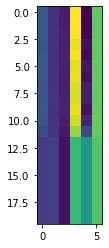

In [35]:
i = 1
tags0 = tags[i]
vowel_prediction0 = vowel_prediction[i]
plt.imshow(vowel_prediction0.detach().numpy()[:20])
print(tags[i])

<AxesSubplot:>

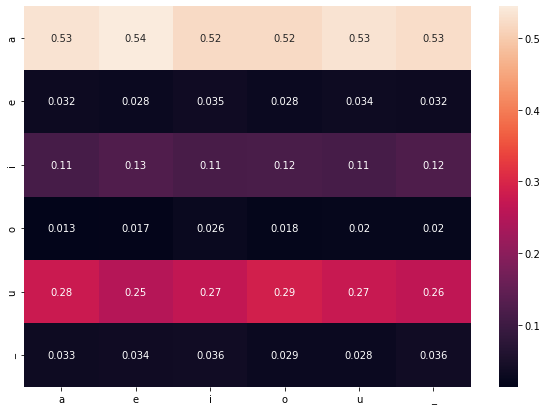

In [27]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

norm_confusion = np.zeros(confusion.shape)
for i in range(0, 6):
    norm_confusion[:, i] = confusion[:, i] / confusion[:, i].sum()
df_cm = pd.DataFrame(norm_confusion, index = [i for i in "aeiou_"],
                  columns = [i for i in "aeiou_"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [14]:
print(confusion)
vowels_dict = {"a":0, "e":1, "i":2, "o":3, "u":4}

[[67734. 70752. 67629. 68796. 71617. 62375.]
 [ 4036.  3697.  4574.  3717.  4525.  3751.]
 [14202. 16237. 14775. 15411. 14932. 14375.]
 [ 1678.  2160.  3345.  2333.  2621.  2428.]
 [35228. 32612. 34669. 37935. 36818. 31354.]
 [ 4137.  4433.  4710.  3766.  3773.  4315.]]


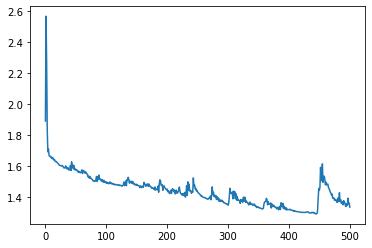

In [22]:
plt.plot(training_curve[:,0])

## Evaluating Trained Model

In [14]:
cf_path = "C:/Users/evansamaa/Desktop/Dataset/models/confusion_matrix_training_curve.npy"
confusion_matrix = np.load(cf_path)
test_acc_path = "C:/Users/evansamaa/Desktop/Dataset/models/test_accuracy_training_curve.npy"
test_acc = np.load(test_acc_path)
train_loss_path = "C:/Users/evansamaa/Desktop/Dataset/models/train_loss_training_curve.npy"
train_loss = np.load(train_loss_path)
test_loss_path = "C:/Users/evansamaa/Desktop/Dataset/models/test_loss_training_curve.npy"
test_loss = np.load(test_loss_path)

(90, 3)


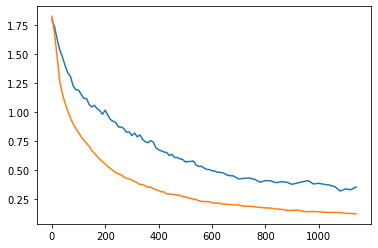

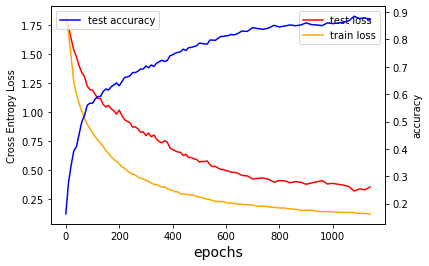

In [25]:
plt.plot(test_loss[:, 0], test_loss[:, 1])
plt.plot(train_loss[:, 0], train_loss[:, 1])
print(test_loss.shape)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(test_loss[:, 0], test_loss[:, 1], label="test loss", color = "red")
ax.plot(train_loss[:, 0], train_loss[:, 1], label="train loss", color = "orange")
# set x-axis label
plt.legend()
ax.set_xlabel("epochs",fontsize=14)
# set y-axis label
ax.set_ylabel("Cross Entropy Loss")

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(test_acc[:, 0], test_acc[:, 1], label="test accuracy", color = "blue")
ax2.set_ylabel("accuracy")
plt.legend()
plt.show()

(1, 6, 6)


<AxesSubplot:>

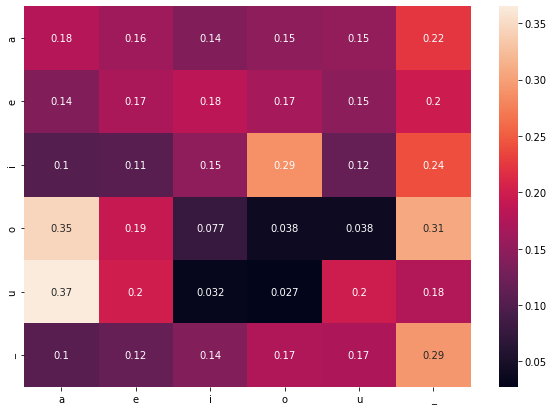

In [28]:
cf_path = "C:/Users/evansamaa/Desktop/confusion_matrix_training_curve.npy"
confusion_matrix = np.load(cf_path)
print(confusion_matrix.shape)
last_confusion = confusion_matrix[-1,:,:]
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

norm_confusion = np.zeros(last_confusion.shape)
for i in range(0, 6):
    norm_confusion[i, :] = last_confusion[i, :] / last_confusion[i, :].sum()
df_cm = pd.DataFrame(norm_confusion, index = [i for i in "aeiou_"],
                  columns = [i for i in "aeiou_"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Qualitative evaluation of model

In [39]:
import pickle

In [40]:
np.load("C:/Users/evansamaa/Desktop/Dataset/train/4_label.npy")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [6]:
model = LSTM_vowel_recognizer_no_BN()
cp = torch.load("C:/Users/evansamaa/Desktop/Dataset/models/model_epoch_2440.pt", map_location=torch.device('cpu'))
model.load_state_dict(cp['model_state_dict'])

<All keys matched successfully>

In [7]:
model2 = LSTM_vowel_recognizer_no_BN()
cp = torch.load("C:/Users/evansamaa/Desktop/Dataset/models/model_epoch_3040.pt", map_location=torch.device('cpu'))
model2.load_state_dict(cp['model_state_dict'])

<All keys matched successfully>

In [22]:
audio_path = "E:/MASC/VocalSet/FULL/female2/arpeggios/belt/f2_arpeggios_belt_a.wav"
audio_path = "C:/Users/evansamaa/Desktop/E_I_E_I.wav"
sound_arr, sr= librosa.load(audio_path, sr = 44100)
sound_arr = (sound_arr-sound_arr.mean())/sound_arr.std()
winstep = 441
mfcc_feat = psf.mfcc(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*winstep, numcep=13)
logfbank_feat = psf.logfbank(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*winstep, nfilt=26)
ssc_feat = psf.ssc(sound_arr, samplerate=sr, winlen=0.02, nfft = 2*winstep, nfilt=26)
full_feat = np.concatenate([mfcc_feat, logfbank_feat, ssc_feat], axis=1)
input_vec = torch.tensor(np.expand_dims(full_feat, axis=0), dtype=torch.float32)
# input_vec = torch.tensor(np.load("C:/Users/evansamaa/Desktop/Dataset/test/1_data.npy", allow_pickle=True), dtype=torch.float32)
print(input_vec.shape)

torch.Size([1, 286, 65])


In [23]:
out = model.test_forward(input_vec).detach().numpy()[:, :500, :]

In [24]:
out2 = model2.test_forward(input_vec).detach().numpy()[:, :500, :]

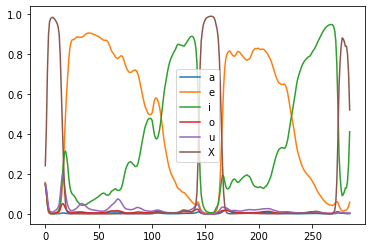

[]

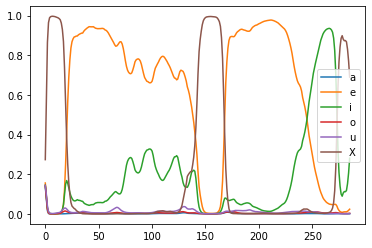

In [25]:
for i in range(0, 6):
    plt.plot(out[0, :, i], label="aeiouX"[i])
# plt.plot(np.argmax(out[0, :], axis=1))
plt.legend()
plt.plot()
plt.show()

for i in range(0, 6):
    plt.plot(out2[0, :, i], label="aeiouX"[i])
# plt.plot(np.argmax(out[0, :], axis=1))
plt.legend()
plt.plot()

   